In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from compressai.entropy_models import EntropyBottleneck

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Compression Model with CompressAI's EntropyBottleneck
class CompressionModel(nn.Module):
    def __init__(self, latent_dim=128):
        super(CompressionModel, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # [1,28,28] -> [64,14,14]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # [64,14,14] -> [64,7,7]
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # [64,7,7] -> [128,7,7]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(),  # [128,7,7] -> [6272]
            nn.Linear(128 * 7 * 7, latent_dim)  # [6272] -> [128]
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * 7 * 7),  # [128] -> [6272]
            nn.ReLU(),
            nn.Unflatten(1, (128, 7, 7)),  # [6272] -> [128,7,7]
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # [128,7,7] -> [64,14,14]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),  # [64,14,14] -> [1,28,28]
            nn.Sigmoid()  # Ensures output is in [0,1]
        )
        
        # CompressAI's EntropyBottleneck for the latent vector
        self.entropy_bottleneck = EntropyBottleneck(channels=latent_dim)
        self.entropy_bottleneck.to(device)

    def forward(self, x):
        latent = self.encoder(x)  # [batch_size, 128]
        # Reshape latent for entropy model: [batch_size, 128, 1, 1]
        latent_reshaped = latent.view(latent.size(0), self.latent_dim, 1, 1)
        # Pass through entropy bottleneck
        y_hat, y_likelihoods = self.entropy_bottleneck(latent_reshaped)
        # Flatten back to [batch_size, 128]
        y_hat = y_hat.view(y_hat.size(0), self.latent_dim)
        reconstruction = self.decoder(y_hat)  # [batch_size, 1, 28, 28]
        return y_hat, reconstruction, y_likelihoods

# Define the Rate-Distortion Loss using CompressAI's EntropyBottleneck
def rate_distortion_loss(y_likelihoods, reconstruction, original, lambda_rd=1.0):
    """
    Computes the combined rate-distortion loss.

    Args:
        y_likelihoods (Tensor): Likelihoods from EntropyBottleneck, shape [batch_size, latent_dim, 1, 1]
        reconstruction (Tensor): Reconstructed data from the decoder, shape [batch_size, 1, 28, 28]
        original (Tensor): Original input data, shape [batch_size, 1, 28, 28]
        lambda_rd (float): Weighting factor between rate and distortion.

    Returns:
        loss (Tensor): Combined loss.
        rate (Tensor): Rate loss (bits per pixel).
        distortion (Tensor): Distortion loss (MSE).
    """
    batch_size = y_likelihoods.size(0)
    num_pixels = original.size(0) * original.size(2) * original.size(3)  # batch_size * 28 * 28

    # Compute rate: sum of negative log2 likelihoods
    # y_likelihoods are the probabilities p(y_hat)
    rate = -torch.log2(y_likelihoods + 1e-10).sum() / num_pixels  # Added epsilon to prevent log(0)

    # Compute distortion: Mean Squared Error
    distortion = F.mse_loss(reconstruction, original)

    # Combined loss
    loss = lambda_rd * distortion + rate
    return loss, rate, distortion

# Initialize the model and optimizer
latent_dim = 128
lambda_rd = 1.0
learning_rate = 1e-3

model = CompressionModel(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training parameters
num_epochs = 2000
batch_size = 64
input_size = (1, 28, 28)  # Grayscale images of size 28x28

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    epoch_rate = 0.0
    epoch_distortion = 0.0
    num_batches = 100  # Number of batches per epoch

    for _ in range(num_batches):
        # Generate random Gaussian data: mean=0.5, std=0.1, clipped to [0,1]
        inputs = torch.randn(batch_size, *input_size, device=device) * 0.1 + 0.5
        inputs = torch.clamp(inputs, 0.0, 1.0)

        optimizer.zero_grad()

        # Forward pass
        y_hat, reconstruction, y_likelihoods = model(inputs)

        # Compute loss
        loss, rate, distortion = rate_distortion_loss(y_likelihoods, reconstruction, inputs, lambda_rd)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate losses
        epoch_loss += loss.item()
        epoch_rate += rate.item()
        epoch_distortion += distortion.item()

    # Average losses over batches
    avg_loss = epoch_loss / num_batches
    avg_rate = epoch_rate / num_batches
    avg_distortion = epoch_distortion / num_batches

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f} | Rate: {avg_rate:.4f} | Distortion: {avg_distortion:.4f}")

print("Training Completed.")


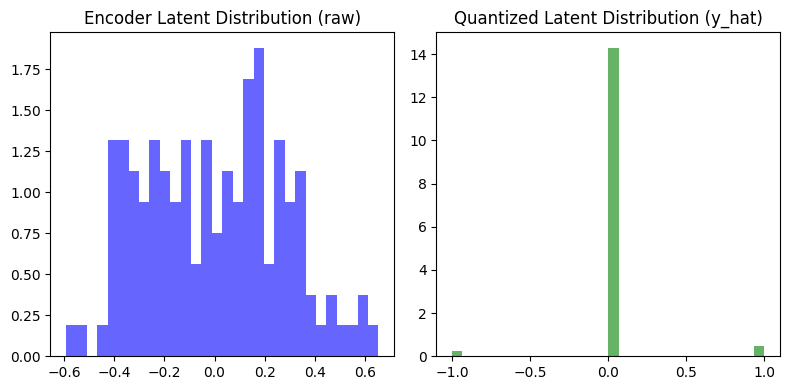

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Suppose you have a trained model
model.eval()

# 1. Create or load a sample test batch
#    Here, just do the same random synthetic data
test_inputs = torch.randn(1, 1, 28, 28, device=device) * 0.1 + 0.5
test_inputs = torch.clamp(test_inputs, 0.0, 1.0)

# 2. Pass it through the encoder
with torch.no_grad():
    latent = model.encoder(test_inputs)  # shape [1, latent_dim]
    latent_reshaped = latent.view(latent.size(0), model.latent_dim, 1, 1)

# 3. Let's get the "noise" or "dequantized" output from the EntropyBottleneck
#    plus the likelihood the bottleneck assigns to that output.
#    (Note: turn off training mode, so we get "dequantize" instead of noise)
model.entropy_bottleneck.eval()
with torch.no_grad():
    y_hat, y_likelihoods = model.entropy_bottleneck(latent_reshaped, training=False)

# Flatten for convenience
# shape [1, latent_dim, 1, 1] -> [latent_dim]
latents_np = latent_reshaped.cpu().view(-1).numpy()
y_hat_np = y_hat.cpu().view(-1).numpy()
likelihoods_np = y_likelihoods.cpu().view(-1).numpy()

# 4. Plot the histogram of the raw latents or the y_hat
plt.figure(figsize=(8, 4))

plt.subplot(1,2,1)
plt.hist(latents_np, bins=30, density=True, alpha=0.6, color='b')
plt.title("Encoder Latent Distribution (raw)")

plt.subplot(1,2,2)
plt.hist(y_hat_np, bins=30, density=True, alpha=0.6, color='g')
plt.title("Quantized Latent Distribution (y_hat)")

plt.tight_layout()
plt.show()

# Optionally, you can also examine 'likelihoods_np' to see how likely
# each quantized value was under the learned distribution.
